In [3]:
import numpy as np
from transformers import LogTformer
from metrics import normalized_gini

from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, MaxoutDense, Reshape
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.optimizers import Adadelta, Adagrad, Adam, RMSprop
from keras.layers.advanced_activations import ParametricSoftplus, PReLU
from keras.regularizers import l2, activity_l2
from keras.callbacks import Callback

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [26]:
X_stack = np.load('saved/X_stack.npy')
y_stack = np.load('saved/y_stack.npy')
print X_stack.shape, y_stack.shape

# scaler = StandardScaler().fit(X_stack)
# X_stack = scaler.transform(X_stack)

bins = [0.5, 1, 1.5, 2.0, 2.5,]
y_binned = np.digitize(LogTformer().fit_transform(y_stack), bins=bins)
print y_binned.shape


(50999, 14) (50999,)
(50999,)


In [27]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        pass
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('val_loss'))
history = LossHistory()
        
n_feats = X_stack.shape[1]
drop_prob = 0.5

model = Sequential()
hidden_size = 128
model.add(Dense(n_feats, hidden_size))
model.add(Dropout(0.2))
model.add(ParametricSoftplus(hidden_size))
model.add(BatchNormalization((hidden_size,)))
model.add(Dropout(drop_prob))
model.add(Dense(hidden_size, hidden_size))
model.add(ParametricSoftplus(hidden_size))
model.add(BatchNormalization((hidden_size,)))
model.add(Dropout(drop_prob))
model.add(Dense(hidden_size, hidden_size))
model.add(ParametricSoftplus(hidden_size))
model.add(BatchNormalization((hidden_size,)))
model.add(Dropout(drop_prob))
model.add(Dense(hidden_size, 1))
model.add(Activation('linear'))

loss_type = 'msle'

opt = RMSprop(lr=0.0005, rho=0.75, epsilon=1e-6)


In [28]:
losses = []
scores = []
clf_baseline = LinearRegression()
# alphas = [0.0001, 0.005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]
# clf_baseline = RidgeCV(alphas=alphas, normalize=True, cv=5)
baseline = []
optimal_bin = []

k = 5
kf = KFold(len(y_stack), n_folds=k)
skf = StratifiedKFold(y_binned, n_folds=k)

for train, val in skf:
    X_train_k = X_stack[train]
    y_train_k = y_stack[train]
    
    X_val_k = X_stack[val]
    y_val_k = y_stack[val]
    
    y_train_binned_k = y_binned[train]
    y_val_binned_k = y_binned[val]
    
    val = (X_val_k, y_val_k)
    
    
    clf_nn = KerasRegressor(model=model, optimizer=opt, loss=loss_type,
                            train_batch_size=1024*4, test_batch_size=1024*16,
                            nb_epoch=200, 
    #                         validation_split=0.1,
                            validation_data=val,
                            verbose=2, callbacks=[history])
    clf_nn.fit(X_train_k, y_train_k)
    
    val_pred = clf_nn.predict(X_val_k)
    scores.append(normalized_gini(y_val_k, val_pred))
    print 'NN scores', scores
    losses.append(history.losses)
    
    # Comparisons
    baseline.append(normalized_gini(
            y_val_k, clf_baseline.fit(
                X_train_k, y_train_k).predict(X_val_k)))
    print 'baseline:', baseline
    
    optimal_bin.append(normalized_gini(y_val_k, y_val_binned_k))
    print 'optimal_bin:', optimal_bin
    
print 'Baseline mean:', np.mean(baseline)
print 'Optimal bin mean:', np.mean(optimal_bin)

Train on 40797 samples, validate on 10202 samples
Epoch 0
0s - loss: 2.2445 - val_loss: 2.1585
Epoch 1
0s - loss: 2.0987 - val_loss: 2.0137
Epoch 2
0s - loss: 1.9372 - val_loss: 1.8192
Epoch 3
0s - loss: 1.6802 - val_loss: 1.4734
Epoch 4
0s - loss: 1.3305 - val_loss: 1.2213
Epoch 5
0s - loss: 1.1999 - val_loss: 1.1622
Epoch 6
0s - loss: 1.1627 - val_loss: 1.0822
Epoch 7
0s - loss: 1.1093 - val_loss: 0.9884
Epoch 8
0s - loss: 1.0646 - val_loss: 0.8983
Epoch 9
0s - loss: 1.0323 - val_loss: 0.8248
Epoch 10
0s - loss: 1.0113 - val_loss: 0.7597
Epoch 11
0s - loss: 0.9831 - val_loss: 0.6997
Epoch 12
0s - loss: 0.9526 - val_loss: 0.6536
Epoch 13
0s - loss: 0.9236 - val_loss: 0.6396
Epoch 14
0s - loss: 0.8997 - val_loss: 0.6171
Epoch 15
0s - loss: 0.8587 - val_loss: 0.5981
Epoch 16
0s - loss: 0.8109 - val_loss: 0.5806
Epoch 17
0s - loss: 0.7621 - val_loss: 0.5624
Epoch 18
0s - loss: 0.7136 - val_loss: 0.5462
Epoch 19
0s - loss: 0.6679 - val_loss: 0.5285
Epoch 20
0s - loss: 0.6272 - val_loss: 0

nn: [0.38508826057567497, 0.3876025060419303, 0.38650093816314934, 0.3907383459757729, 0.3736896211124942] 0.384723934374
LinReg: [0.3858122560304648, 0.3879104373238173, 0.38537161283053983, 0.3917754793043471, 0.37358062503751727] 0.384890082105


(0.38, 0.41)

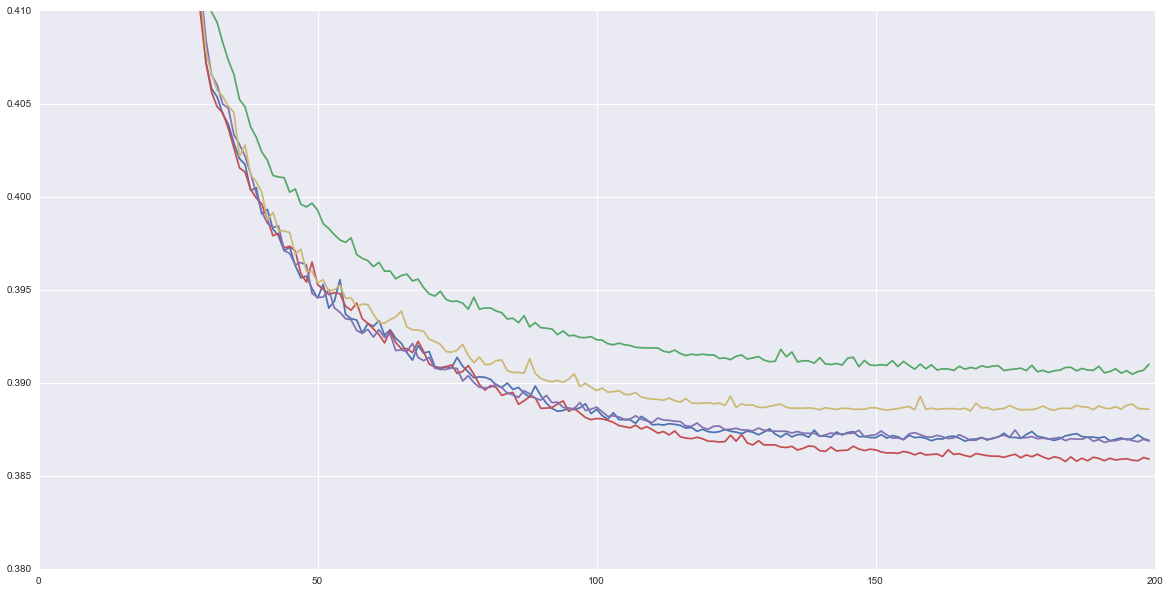

In [33]:
print 'nn:', scores, np.mean(scores)
print 'LinReg:', baseline, np.mean(baseline)

plt.figure(figsize=(20,10))
# plt.plot(np.mean(losses, axis=0))
plt.plot(np.array(losses).T)
plt.ylim([0.38, 0.41])
# plt.ylim([13.5, 15])

In [ ]:
# 0.384942531731 msle
# 0.385735408898 mse
# 0.38553051574 mse
